# Bayesian Deep Learning


This tutorial based on [NeurIPS 2021: Laplace Redux -- Effortless Bayesian Deep Learning](https://www.youtube.com/watch?v=nMONiYLWWOU)

### $$\text{Given } D:= \{ (x_i ,y_i) \}_{i=1} ^N $$ 

### $$\Theta_{\text{MAP}} = argmax_\Theta \sum_{i=1} ^N log p(y_i | f_\Theta (x_i)) + log p(\Theta) $$


$\Theta_{\text{MAP}} \text{ is only the mode of posterior } p(\Theta | D)$

## Intro: The Laplace Approximation

### 1. Get a MAP estimation to obtain $\Theta_{\text{MAP}}$

### 2. Construct a local apporximation $$ p(\Theta | D) \approx N(\Theta_{\text{MAP}}, (-\nabla^2 _\Theta log p(\Theta | D) | \Theta_{\text{MAP}})^-1)=: \color{red} {q(\Theta)}$$



### 3. Make prediction
$$ p(y | D) \approx \int p(y | \Theta, x_*) \color{red} {q(\Theta)} d\Theta$$

### Setting
$$ D:= \{ (x,y)_i \}_{i=1} ^N $$


$$ \Theta_{\text{MAP}} = \textrm{arg max}_\Theta \sum_{i=1} ^N \textrm{log} P(y_i \mid f_\Theta (x_i)) + \textrm{log} P(\Theta)$$


From Bayesian Pespective, $\Theta_{\text{MAP}}$ is only the mode of posterior $P( \Theta \mid D)$, i.e., uncertainty is not measured.

# Laplace Approximation
1. Map estimation to obtain $  \Theta_{\text{MAP}} $
2. Construct a local approximation

$$ P( \Theta \mid D) \approx N ( \Theta_{\textrm{MAP}}, (- \nabla ^2 _\Theta \; \textrm{log} P ( \Theta \mid D ) \mid  \Theta_{\textrm{MAP}})^{-1} ) =: q(\Theta)$$

***(2) indicates that we use $\Theta_{\textrm{MAP}}$ as a mean of the gaussian distribution and the negative of the inverse Hesian of the loss as the covariant matrix.***


3. Inference

$$ P(y | D) \approx \int P (y \mid \Theta, x_*) q(\Theta) d\Theta$$

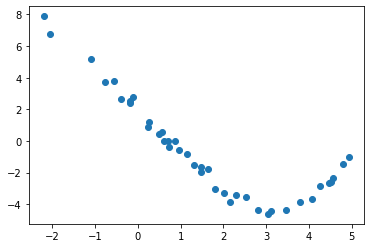

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
%matplotlib inline

x = np.random.uniform(low=-3, high=5, size=(40,1))
y = 0.1*x**3 - 3*x + 2 + np.random.normal(scale=0.3, size=x.shape)
plt.scatter(x,y)

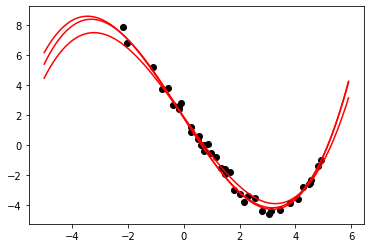

In [2]:
def phi(x):
    design_matrix = np.concatenate([np.ones(x.shape), x, x**2, x**3], axis=1)
    return design_matrix
def posterior_pred(x, alpha,beta, phi):
    result = alpha * np.identity(phi(x).shape[1])
    result += beta * np.dot(phi(x).T, phi(x))
    return result
def posterior(x, alpha,beta, phi):
    posterior_precision =posterior_pred(x,alpha,beta,phi)
    posterior_mean=beta * np.dot(np.linalg.inv(posterior_precision),np.dot(phi(x).T, y))
    return posterior_precision, posterior_mean

#print(x.shape, phi(x).shape)
#phi(x)[0] # 1, x, x**2, x**3

alpha = 1
beta = 1/0.4

posterior_precision,posterior_mean=posterior(x, alpha, beta, phi)
plt.scatter(x,y, c='k')
ar = np.arange(-5,6, 0.1).reshape(-1,1)

for i in range(3):
    w_sample = np.random.multivariate_normal(posterior_mean.ravel(), 
                                             np.linalg.inv(posterior_precision))
    plt.plot(ar, np.dot(phi(ar),w_sample), c='r')

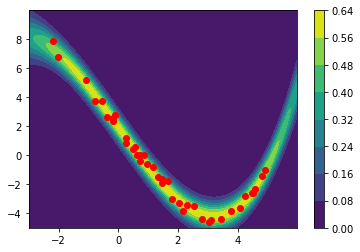

In [3]:
xs, ys = np.meshgrid(np.arange(-3,6,0.01), np.arange(-5,10,0.01))
px = phi(xs.reshape(-1,1))
px.shape

sn = np.linalg.inv(posterior_precision)


predictive_var = 1/beta + (px @ sn * px).sum(axis=1)
predictive_mean = px @ posterior_mean


z = norm.pdf(ys.ravel(), loc = predictive_mean.ravel(), scale=predictive_var**0.5)


plt.contourf(xs, ys, z.reshape(xs.shape))
plt.colorbar()
plt.scatter(x,y, c='r')

# Laplace Library

In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

from laplace import Laplace
import matplotlib.pyplot as plt

## Regression Example

In [5]:
# Generate data

n_epochs = 1000
batch_size = 150  # full batch
true_sigma_noise = 0.3

# create simple sinusoid data set
X_train = (torch.rand(150) * 8).unsqueeze(-1)
y_train = torch.sin(X_train) + torch.randn_like(X_train) * true_sigma_noise
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size)
X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)  # +-5 on top of the training X-range

In [6]:
# create and train MAP model
model = torch.nn.Sequential(torch.nn.Linear(1, 50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50, 1))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=5e-4, lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

In [7]:
#subset_of_weights: all, 'last_layer'
# hessian_structure, 'full', 'kron', 'diag'
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [8]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

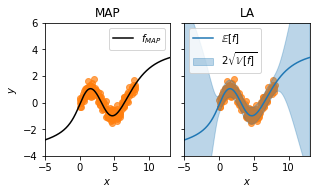

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,
                               figsize=(4.5, 2.8))
ax1.set_title('MAP')
ax1.scatter(X_train.flatten(), y_train.flatten(), alpha=0.7, color='tab:orange')
ax1.plot(x, f_mu, color='black', label='$f_{MAP}$')
ax1.legend()

ax2.set_title('LA')
ax2.scatter(X_train.flatten(), y_train.flatten(), alpha=0.7, color='tab:orange')
ax2.plot(x, f_mu, label='$\mathbb{E}[f]$')
ax2.fill_between(x, f_mu-pred_std*2, f_mu+pred_std*2, 
                 alpha=0.3, color='tab:blue', label='$2\sqrt{\mathbb{V}\,[f]}$')
ax2.legend()
ax1.set_ylim([-4, 6])
ax1.set_xlim([x.min(), x.max()])
ax2.set_xlim([x.min(), x.max()])
ax1.set_ylabel('$y$')
ax1.set_xlabel('$x$')
ax2.set_xlabel('$x$')
plt.tight_layout()
plt.show()